In [ ]:
!pip install gym #0.17.3
!pip install jupyterplot

In [ ]:
import numpy as np
import gym
from copy import copy
from gym.envs.registration import register
%matplotlib inline
import seaborn
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import random as rd
from collections import defaultdict
import functools
from tqdm.notebook import tqdm
from numpy.linalg import norm
from jupyterplot import ProgressPlot

def fancy_visual(value_func,policy_int):    
    grid = 4    
    f, ax = plt.subplots(figsize=(11, 9))
    cmap = seaborn.diverging_palette(220, 10, as_cmap=True)
    reshaped = np.reshape(value_func,(grid,grid))
    seaborn.heatmap(reshaped, cmap="icefire",vmax=1.1, robust = True,
                square=True, xticklabels=grid+1, yticklabels=grid+1,
                linewidths=.5, cbar_kws={"shrink": .5}, ax=ax, annot=True, fmt="f")
    counter = 0
    for j in range(0, 4):
        for i in range(0, 4):
            if int(policy_int[counter]) == 1:
                # down
                plt.text(i+0.5, j+0.7, u'\u2193', fontsize=12)
            elif int(policy_int[counter]) == 3:
                # up
                plt.text(i+0.5, j+0.7, u'\u2191', fontsize=12)
            elif int(policy_int[counter]) == 0:
                # right
                plt.text(i+0.5, j+0.7, u'\u2190', fontsize=12)
            else:
                # left
                plt.text(i+0.5, j+0.7, u'\u2192', fontsize=12)
            counter=counter+1

    plt.title('Heatmap of policy iteration with value function values and directions')
    print('Value Function',value_func)
    print('Policy',policy_int)
    plt.show()

# test_value = np.random.rand(16) #Random Value Function (only for plotting)
# test_policy = np.random.randint(0,3,16) #Random Policy (only for plotting)
# print(test_value)
# print(test_policy)

register(
    id='D4x4-FrozenLake-v0',
    entry_point='gym.envs.toy_text.frozen_lake:FrozenLakeEnv',
    kwargs={'map_name': '4x4',
            'is_slippery': True})
# transition kernal is not determinstic
env = gym.make('D4x4-FrozenLake-v0')

In [6]:
gamma = 0.9
theta = 1e-06
env.reset()
env.seed(0)
def value_iteration(env):
    # pp = ProgressPlot(line_names=['value delta'])
    v_ = np.zeros(env.nS)
    theta = 1e-9
    for i in range(100000):
        u_v_ = np.copy(v_)

        for state in range(env.nS):
            Q_value = []
            for action in range(env.nA):
                n_rewards = []
                for n_ in env.P[state][action]:
                    t_prob, n_state, reward, terminal = n_
                    n_rewards.append((t_prob*(reward+gamma*u_v_[n_state])))
                    Q_value.append(np.sum(n_rewards))
                    v_[state] = max(Q_value)
        delta = np.sum(norm(u_v_-v_))
        # pp.update(delta)
        if(delta <= theta):break
    # pp.finalize()
    return v_

def get_policy_and_optimal_q(v_):
    policy = np.zeros(env.nS)
    optimal_q = []
    for state in range(env.nS):
        Q = np.zeros(env.nA)
        for action in range(env.nA):
            for n_ in env.P[state][action]:
                t_prob, n_state, reward, terminal = n_
                Q[action] += (t_prob * (reward+gamma*v_[n_state]))
        policy[state] = np.argmax(Q)
        optimal_q.append(Q)
    return policy, optimal_q

value = value_iteration(env)
policy, optimal_q = get_policy_and_optimal_q(value)

In [ ]:
import tensorflow as tf
opt = tf.keras.optimizers.SGD(learning_rate=0.9)
var = tf.Variable(1.0)
loss = lambda: (var ** 2)/2.0

for i in range(1000):
    step_count = opt.minimize(loss, [var]).numpy()
    v = var.numpy()
    print(step_count, v)

In [51]:
step_count
step_count = opt.minimize(loss, [var]).numpy()

In [53]:
var.numpy()

0.198005

In [93]:
class TabularQL(object):
    
    def __init__(self, env, optimal_q):
        self.action_space = env.action_space
        self.optimal_q = optimal_q
        self.config = {
            "lr": 0.9,
            "epsilon": 1.0,            
            "gamma": 0.9,
            "max_iter": 10000,
            "episode": 5000,
            "decay": 0.9
            }
        self.minimal_config = 1e-3

        self.q = np.zeros((env.nS, env.nA))
        #  defaultdict(functools.partial(lambda n: [0]*n, n=env.nA))
        self.crs = []
        self.delta_qs = []

    def policy(self):
        return np.argmax(self.q, axis=1)
    def value(self):
        return  np.max(self.q, axis=1)

    def plot_mv(self, array):
        average_list = []
        width = 50
        for i in range(len(array) - width):
            average_list.append(np.sum([array[i+x] for x in range(width)]) / width)
        plt.plot(average_list)
        plt.show()
        return average_list

    def greedy(self, state, epsilon=None):
        if epsilon is None:
            epsilon = self.config["epsilon"]      
        # epsilon greedy
        if np.random.random() > epsilon:
            return np.argmax(self.q[state])
        else:
            while True:
                action = self.action_space.sample()
                if action != np.argmax(self.q[state]): break
        return action

    def declay_para(self, episode):
        if episode % 100 == 0:            
            if self.config["lr"] > self.minimal_config:
                self.config["lr"] *= self.config["decay"]
            if self.config["epsilon"] > self.minimal_config:
                self.config["epsilon"] *= self.config["decay"]
            if self.config["decay"] < 0.99:
                self.config["decay"] *= (1 + 1e-5)

    def qlearning(self, env):
        pp = ProgressPlot(plot_names=["cumulative_reward", "delta_q"])

        env.reset()
        cr = []
        for episode in tqdm(range(self.config['episode'])):
            self.declay_para(episode)
            
            lr = self.config["lr"]
            gamma = self.config["gamma"]
            state = env.reset()
            cumulative_reward = 0
            for t in range(self.config["max_iter"]):
                action = self.greedy(state)
                state_, reward, terminal, _ = env.step(action)

                q_ = np.max(self.q[state_]) if not terminal else 0.0

                self.q[state][action] = self.q[state][action] + lr * (reward + gamma * q_ - self.q[state][action])
                
                state = state_

                cumulative_reward += reward
                if terminal:
                    break
            delta_q = norm(self.q - self.optimal_q) 
            pp.update([[cumulative_reward],
                       [delta_q]])
            self.crs.append(cumulative_reward)
            self.delta_qs.append(delta_q)
        pp.finalize()
        return cumulative_reward
        

env.reset()
env.seed(0) 
tql = TabularQL(env, optimal_q)
cumulative_reward = tql.qlearning(env)

In [94]:
tql.q

array([[0.07011807, 0.06183292, 0.06140574, 0.05652179],
       [0.03598385, 0.03473908, 0.03471236, 0.05907908],
       [0.07057672, 0.05812979, 0.06220871, 0.05266308],
       [0.04186511, 0.03347005, 0.02807206, 0.04740893],
       [0.09288069, 0.06453795, 0.05704847, 0.04876631],
       [0.        , 0.        , 0.        , 0.        ],
       [0.10814826, 0.07540718, 0.07661413, 0.02203308],
       [0.        , 0.        , 0.        , 0.        ],
       [0.06648196, 0.08960324, 0.09962022, 0.14180915],
       [0.14426947, 0.24140244, 0.16107912, 0.11135073],
       [0.28487848, 0.21782937, 0.22169767, 0.10915977],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.20418839, 0.25325068, 0.36512921, 0.30626417],
       [0.37763319, 0.64103681, 0.52078796, 0.51196304],
       [0.        , 0.        , 0.        , 0.        ]])

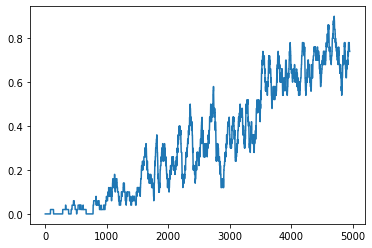

In [95]:
# moving average/ sliding windows
s = tql.plot_mv(tql.crs)

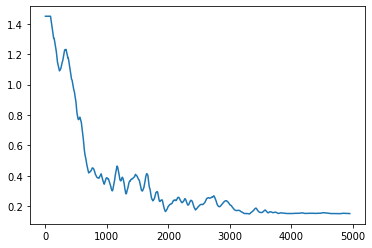

In [96]:
# moving average/ sliding windows
s = tql.plot_mv(tql.delta_qs)

Value Function [0.07011807 0.05907908 0.07057672 0.04740893 0.09288069 0.
 0.10814826 0.         0.14180915 0.24140244 0.28487848 0.
 0.         0.36512921 0.64103681 0.        ]
Policy [0 3 0 3 0 0 0 0 3 1 0 0 0 2 1 0]


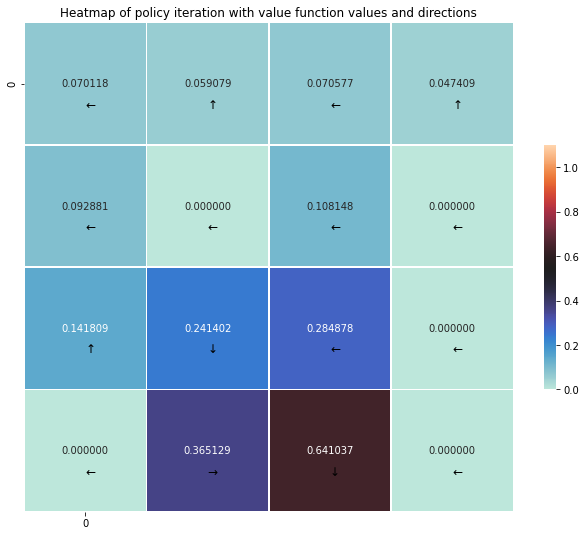

In [97]:
fancy_visual(tql.value(), tql.policy())

In [99]:
%%shell
jupyter nbconvert --to html /content/QL.ipynb

[NbConvertApp] Converting notebook /content/QL.ipynb to html
[NbConvertApp] Writing 1181738 bytes to /content/QL.html
